In [1]:
import numpy as np

def quantile_V(theta, m, alpha, gamma, s, s_dash, r):
    # サンプル数を指定した一様分布からサンプリングする関数
    # T回の更新を実施

        # 各Quantileインデックスに対する更新
    for i in range(1,m+1):
        tau_i = (2*i - 1) / (2*m)
        update = alpha * (tau_i - (1 / m) * np.sum(theta[s, i] - r - gamma * theta[s_dash, :] < 0))
        theta_prime = theta[s, i] + update
        theta[s, i] = theta_prime

    # 最終的な結果として各状態におけるQuantile推定値の平均を返す
    return np.mean(theta, axis=-1)

In [2]:
import numpy as np
S = 16 #状態数
A = 4 #行動数
seed = 42
np.random.seed(seed)
import gymnasium as gym

rew = np.zeros((S,A))
rew[14,1] = 1.0
rew[14,2] = 1.0
rew[14,3] = 1.0
# print(np.sum(P, axis=2))
policy = np.ones((S,A))
policy = policy / A # uniform policy
epsilon = [3/10,4/10,5/10,6/10,7/10,8/10,9/10,1.0]
def create_env(epsilon):
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    P = np.zeros((S,A,S))
    epsilon = epsilon
    for s in range(S):
        for a in range(A):
            Ps_dash = env.P[s]
            Psa_dash = Ps_dash[a]
            if a == 1:
                selected_elements = [item[1] for item in Psa_dash]
                index = [index for index, value in enumerate(selected_elements) if value == s+a+3]
                if not index:
                    index = [index for index, value in enumerate(selected_elements) if value ==s]
            elif a== 0 or a== 2:
                selected_elements = [item[1] for item in Psa_dash]
                index = [index for index, value in enumerate(selected_elements) if value == s+a-1]
                if not index:
                    index = [index for index, value in enumerate(selected_elements) if value ==s]
            elif a== 3:
                selected_elements = [item[1] for item in Psa_dash]
                index = [index for index, value in enumerate(selected_elements) if value == s+a-7]
                if not index:
                    index = [index for index, value in enumerate(selected_elements) if value ==s]
            # Psa_dash = Ps_dash[a]
            # print(len(Psa_dash))
            if len(Psa_dash) != 1:
                for t in range(len(Psa_dash)):
                    if index:
                        if t == index[0]:
                            P_ = epsilon
                            s_dash = Psa_dash[t][1]
                            P[s,a,s_dash] += P_
                            # print('a')
                        else:
                            P_ = (1-epsilon) / 2
                            s_dash = Psa_dash[t][1]
                            P[s,a,s_dash] += P_
                            # print('aaa')
            else:
                for t in range(len(Psa_dash)):
                    P_ = Psa_dash[t][0]
                    s_dash = Psa_dash[t][1]
                    P[s,a,s_dash] += P_
    return P

from typing import NamedTuple, Optional
class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  #ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    robust_optimal_Q: Optional[np.ndarray] = None  # ロバスト最適Q値
    optimal_policy: Optional[np.ndarray] = None  # 最適方策

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)

rew = np.zeros((S,A))
rew[14,1] = 1.0
rew[14,2] = 1.0
rew[14,3] = 1.0

# np.testing.assert_almost_equal(np.sum(P, axis=2), np.ones((S,A)))
# print(np.sum(P, axis=2))
policy = np.ones((S,A))
policy = policy / A # uniform policy
P = np.zeros((S,A,S))

S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.9
horizon = 1000
#MDPを作成
mdp = MDP(S_array, A_array, gamma, horizon, rew, P)

In [3]:
def Sample_Collect(iteration,train_p,seed):
    np.random.seed(seed)
    steps = 0
    P = create_env(train_p)
    env_d = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
    S,A = env_d.observation_space.n,env_d.action_space.n
    policy_b = np.ones((S,A))/A
        # steps = 0
    sample_list = {'state':[],'action':[],'reward':[],'next_state':[],'done':[],'done_':[]}
    while True:
        if steps >=iteration:
            break
        s = env_d.reset()[0]
        for _ in range(horizon):
            a = np.random.choice(a=4,size=1,p=policy_b[s])[0]
            steps +=1
            s_dash = np.random.choice(a=16,size=1,p=P[s,a])[0]
            if s_dash == s - 1:  # 左に移動した場合
                a = 0  # 行動0を返す
            elif s_dash == s + 4:  # 下に移動した場合
                a = 1  # 行動1を返す
            elif s_dash == s + 1:  # 右に移動した場合
                a = 2  # 行動2を返す
            elif s_dash == s - 4:  # 上に移動した場合
                a = 3  # 行動3を返す
            s_,r,d,d_,_ = env_d.step(a)
            sample_list['state'].append(s)
            sample_list['action'].append(a)
            sample_list['reward'].append(r)
            sample_list['next_state'].append(s_)
            sample_list['done'].append(d)
            sample_list['done_'].append(d_)
            s = s_
                # print(i)
            if d or d_:
                    # print('a')
                break
    return sample_list

In [4]:
sample = Sample_Collect(3000,0.9,1)

/users/y-ichihara/.conda/envs/syumi-note/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.P to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.P` for environment variables or `env.get_attr('P')` that will search the reminding wrappers.
  logger.warn(


In [14]:
from tqdm import tqdm
def Quantile_TD_Learning(R,learning_rate,gamma,test_eps,iteration,sample_list,seed,m):
    np.random.seed(seed)
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
    S_,A_ = env.observation_space.n,env.action_space.n
    P = create_env(test_eps)
    Q = np.zeros((S_,A_))
    rewards = []
    theta = np.zeros((S_,A_,m))
    theta_prime = np.zeros((S_,A_,m))
    # print(theta.shape)
    for t in tqdm(range(iteration)):
        # cul = 0
        s,a,s_dash,r,d,d_ = sample_list['state'][t],sample_list['action'][t],sample_list['next_state'][t],sample_list['reward'][t],sample_list['done'][t],sample_list['done_'][t]
        for i in range(1,m+1):
            cul = 0
            tau_i = (2*i - 1) / (2*m)
            Q = np.mean(theta, axis=-1)
            max_a = np.argmax(Q[s_dash])
            # update = learning_rate * (tau_i - (1 / m) * np.sum(theta[s, a,i-1] - r - (1-int(d))*(1-int(d_))*gamma * np.mean(theta[s_dash,:, :],axis=1) < 0,axis=-1))
            for j in range(1,m+1):
                cul += tau_i - (-theta[s, a,i-1] + r + (1-int(d))*(1-int(d_))*gamma * theta[s_dash,max_a,j-1] < 0)
            # update = learning_rate *(1/m)*np.sum(tau_i - (-theta[s, a,i-1] + r + (1-int(d))*(1-int(d_))*gamma * theta[s_dash,max_a,:] < 0),axis=-1)
            update = learning_rate * (1/m) * cul
            theta_prime[s,a,i-1] = theta[s,a, i-1] + update
        theta[s,a,:] = theta_prime[s,a,:]
        Q = np.mean(theta, axis=-1)
        S = env.reset()[0]
        for _ in range(100):
            A = np.argmax(Q[S])
            S_DASH = np.random.choice(a=16,size=1,p=P[S,A])[0]
            if S_DASH == S - 1:  # 左に移動した場合
                A = 0  # 行動0を返す
            elif S_DASH == S + 4:  # 下に移動した場合
                A = 1  # 行動1を返す
            elif S_DASH == S + 1:  # 右に移動した場合
                A = 2  # 行動2を返す
            elif S_DASH == S - 4:  # 上に移動した場合
                A = 3  # 行動3を返す
            S_,R,D,D_,_ = env.step(A)
            S = S_
            # if R != 0.0:
            #     print('a')
            # print(steps)
            if D or D_:
                rewards.append(R)
                # print(R)
                break
    return rewards,Q

In [55]:
from tqdm import tqdm
def Expectile_TD_Learning(R,learning_rate,gamma,test_eps,iteration,sample_list,seed,m):
    np.random.seed(seed)
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
    S_,A_ = env.observation_space.n,env.action_space.n
    P = create_env(test_eps)
    Q = np.zeros((S_,A_))
    rewards = []
    theta = np.zeros((S_,A_,m))
    theta_prime = np.zeros((S_,A_,m))
    # print(theta.shape)
    for t in tqdm(range(iteration)):
        s,a,s_dash,r,d,d_ = sample_list['state'][t],sample_list['action'][t],sample_list['next_state'][t],sample_list['reward'][t],sample_list['done'][t],sample_list['done_'][t]
        for i in range(1,m+1):
            cul = 0
            tau_i = (2*i - 1) / (2*m)
            Q = np.mean(theta, axis=-1)
            max_a = np.argmax(Q[s_dash])
            # update = learning_rate *(1/m)*np.sum(2*(r + (1-int(d))*(1-int(d_)) * gamma * theta[s_dash,max_a,:] - theta[s,a,i-1]) *(tau_i - (-theta[s, a,i-1] + r + (1-int(d))*(1-int(d_))*gamma * theta[s_dash,max_a,:] < 0)),axis=-1)
            for j in range(1,m+1):
                cul += 2*np.abs(r + (1-int(d))*(1-int(d_)) * gamma * theta[s_dash,max_a,j-1] - theta[s,a,i-1]) *(tau_i - (-theta[s, a,i-1] + r + (1-int(d))*(1-int(d_))*gamma * theta[s_dash,max_a,j-1] < 0))
                update = learning_rate * (1/m) * cul
            theta_prime[s,a,i-1] = theta[s,a, i-1] + update 
        theta[s,a,:] = theta_prime[s,a,:]
        Q = np.mean(theta, axis=-1)
        # index_i = (m+1)/2
        # Q = theta[:,:,-1,index_i-1]
        S = env.reset()[0]
        for _ in range(100):
            A = np.argmax(Q[S])
            S_DASH = np.random.choice(a=16,size=1,p=P[S,A])[0]
            if S_DASH == S - 1:  # 左に移動した場合
                A = 0  # 行動0を返す
            elif S_DASH == S + 4:  # 下に移動した場合
                A = 1  # 行動1を返す
            elif S_DASH == S + 1:  # 右に移動した場合
                A = 2  # 行動2を返す
            elif S_DASH == S - 4:  # 上に移動した場合
                A = 3  # 行動3を返す
            S_,R,D,D_,_ = env.step(A)
            S = S_
            # if R != 0.0:
            #     print('a')
            # print(steps)
            if D or D_:
                rewards.append(R)
                # print(R)
                break
    return rewards,Q

In [56]:
def calculate_average_rewards(rewards):
    # 累積報酬の計算
    cumulative_rewards = np.cumsum(rewards)

    average_rewards = cumulative_rewards / np.arange(1, len(rewards) + 1)

    return average_rewards

In [57]:
R = 0.5
learning_rate = 0.8
gamma = 0.9
test_eps = 0.9
iteration = len(sample['state'])
tau = 50
eta = 0.5
m = 11

In [58]:
reward,Q = Expectile_TD_Learning(R,learning_rate,gamma,test_eps,iteration,sample,123,m)

100%|██████████| 3007/3007 [00:08<00:00, 334.51it/s]


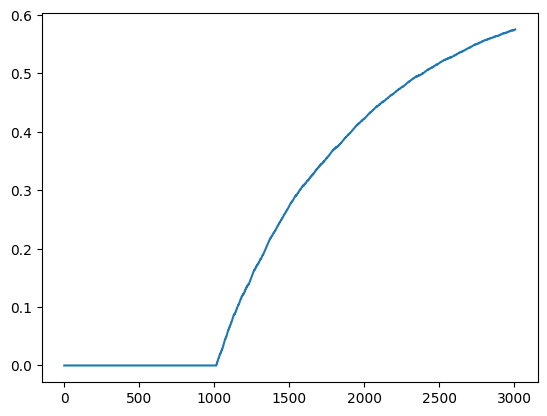

In [59]:
import matplotlib.pyplot as plt
ave_reward = calculate_average_rewards(reward)
plt.plot(ave_reward)

100%|██████████| 3007/3007 [00:05<00:00, 577.67it/s]


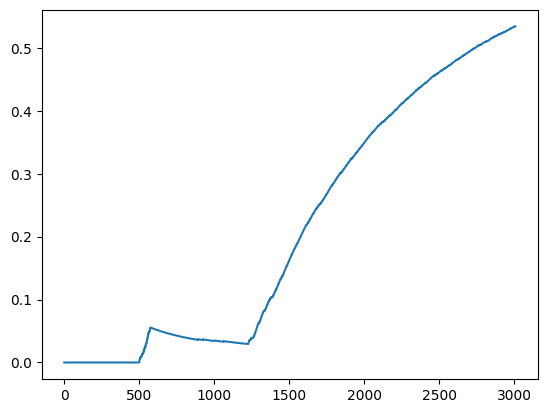

In [60]:
rewards,_ = Quantile_TD_Learning(R,learning_rate,gamma,test_eps,iteration,sample,123,m)

import matplotlib.pyplot as plt
ave_rewards = calculate_average_rewards(rewards)
plt.plot(ave_rewards)

In [171]:
ave_reward

array([0.        , 0.        , 0.        , ..., 0.01231281, 0.01230872,
       0.01230462])

In [77]:
Q[13]

array([ 2.8    , -3.6    , -0.57536, -2.11288])